In [29]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from pytensor import gradient

from astropy.io import fits
from astropy.modeling import models


from scipy.signal import find_peaks

# Custom fitter
from astropy.modeling.models import custom_model

import corner
import arviz as az
az.style.use("arviz-darkgrid")

from astropy.constants import c
def LSRtoFreq(V):
    return -(V / c.value * I_h['RESTFREQ'] - I_h['RESTFREQ'])

def FreqtoLSR(f):
    return c.value * (I_h['RESTFREQ'] - f) / I_h['RESTFREQ']

def guess_gen(spec, n_dist):
    guess = []
    peaks, info = find_peaks(spec, height=0., prominence=0.2, width = 0)
    if len(peaks) != len(n_dist): 
        print("Mapping doesn't match. Defaults to 1 instead.")
        n_dist = np.ones(len(peaks))*1
    for i in range(len(peaks)):
        center = peaks[i]
        width = info['widths'][i] * 0.6
        n = n_dist[i]
        if n == 1: 
            guess.append(spec[int(center)])
            guess.append(center)
            guess.append(width / n)
            continue
        for j in np.linspace(center - width, center + width, n):
            guess.append(spec[int(j)])
            guess.append(j)
            guess.append(width / n)

    return guess

# Spectral cube needs to be in the same working directory
name = 'DR21W'
I_hdu = fits.open(name + '_I.FITS')
I_d = np.squeeze(I_hdu[0].data)
I_h = I_hdu[0].header

V_hdu = fits.open(name + '_V.FITS')
V_d = np.squeeze(V_hdu[0].data)
V_h = V_hdu[0].header

# Reading the spectrum of the selected pixel
#Maser B
x = 128
y = 127

#Maser A
# x = 147
# y = 134

start = None
end = None
spec = I_d[start:end, x, y]
V = V_d[start:end, x, y]
d_nu = I_hdu[0].header['CDELT3']
nu_init = I_hdu[0].header['CRVAL3']
x_axis = (np.arange(len(spec)) * d_nu + nu_init) / 1e9
ref_vel = I_h['ALTRVAL']
ref_pix = I_h['ALTRPIX']
vel_axis = (ref_vel + (np.arange(len(spec)) - ref_pix + 2) * (FreqtoLSR(nu_init) - FreqtoLSR(nu_init + d_nu))) / 1e3

[42.737286,
 122.06532780185222,
 2.6448907327159277,
 130.73213,
 130.0,
 2.6448907327159277,
 59.42556,
 137.93467219814778,
 2.6448907327159277]

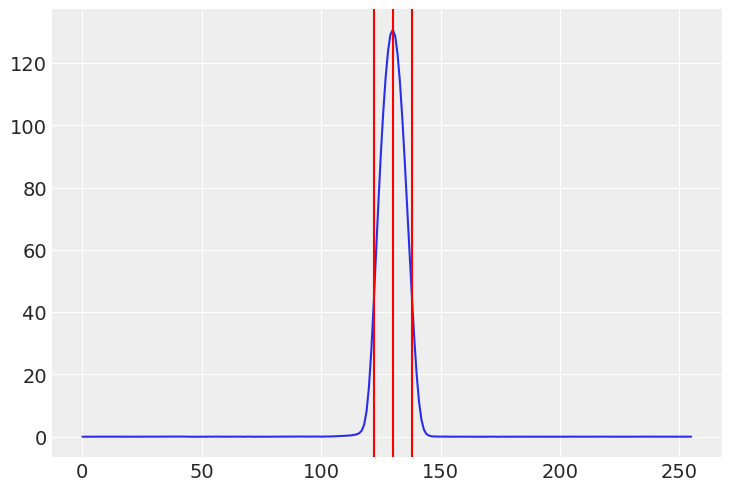

In [37]:
guess = guess_gen(spec, [3])
num = len(guess) // 3
plt.plot(spec)
for i in range(num):
    plt.axvline(guess[3 * i + 1], color='r')
    # plt.plot([guess[3 * i + 1], guess[3 * i + 1]], [0, guess[3 * i]], 'r')
guess

In [38]:
basic_model = pm.Model()

xs = np.arange(len(spec))
with basic_model as model:
    xdata = pm.ConstantData("x", xs)
    # Priors for unknown model parameters
    amp = pm.Uniform("amp", lower=0, upper=np.max(spec)*1.2, shape = num)
    mu = pm.Normal("mu", mu=guess[1::3], sigma=10, shape = num, transform=pm.distributions.transforms.univariate_ordered)
    sigma = pm.HalfNormal("sigma", sigma=10, shape=num)

    gauss_sum = np.sum([amp[i] * pm.math.exp(-0.5 * ((xdata - mu[i]) / sigma[i]) ** 2) for i in range(num)], axis=0)
    # Likelihood (sampling distribution) of observations
    likelihood = pm.Normal("y", mu=gauss_sum, observed=spec, sigma=0.01)

    # inference
    trace = pm.sample(draws=10_000, tune=5_000, cores = 24, chains = 24, discard_tuned_samples=False, step = pm.NUTS(),
                      initvals={'amp': guess[0::3], 'mu': guess[1::3], 'sigma': guess[2::3]})

Multiprocess sampling (24 chains in 24 jobs)
NUTS: [amp, mu, sigma]


Sampling 24 chains for 5_000 tune and 10_000 draw iterations (120_000 + 240_000 draws total) took 447 seconds.


/users/rhsu/micromamba/envs/pymc_env/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


Amp:	39.92	Center:	124.45	Width:	2.82
Amp:	122.95	Center:	130.26	Width:	4.02
Amp:	30.34	Center:	136.31	Width:	2.86
Chi2: 4.500610604109031


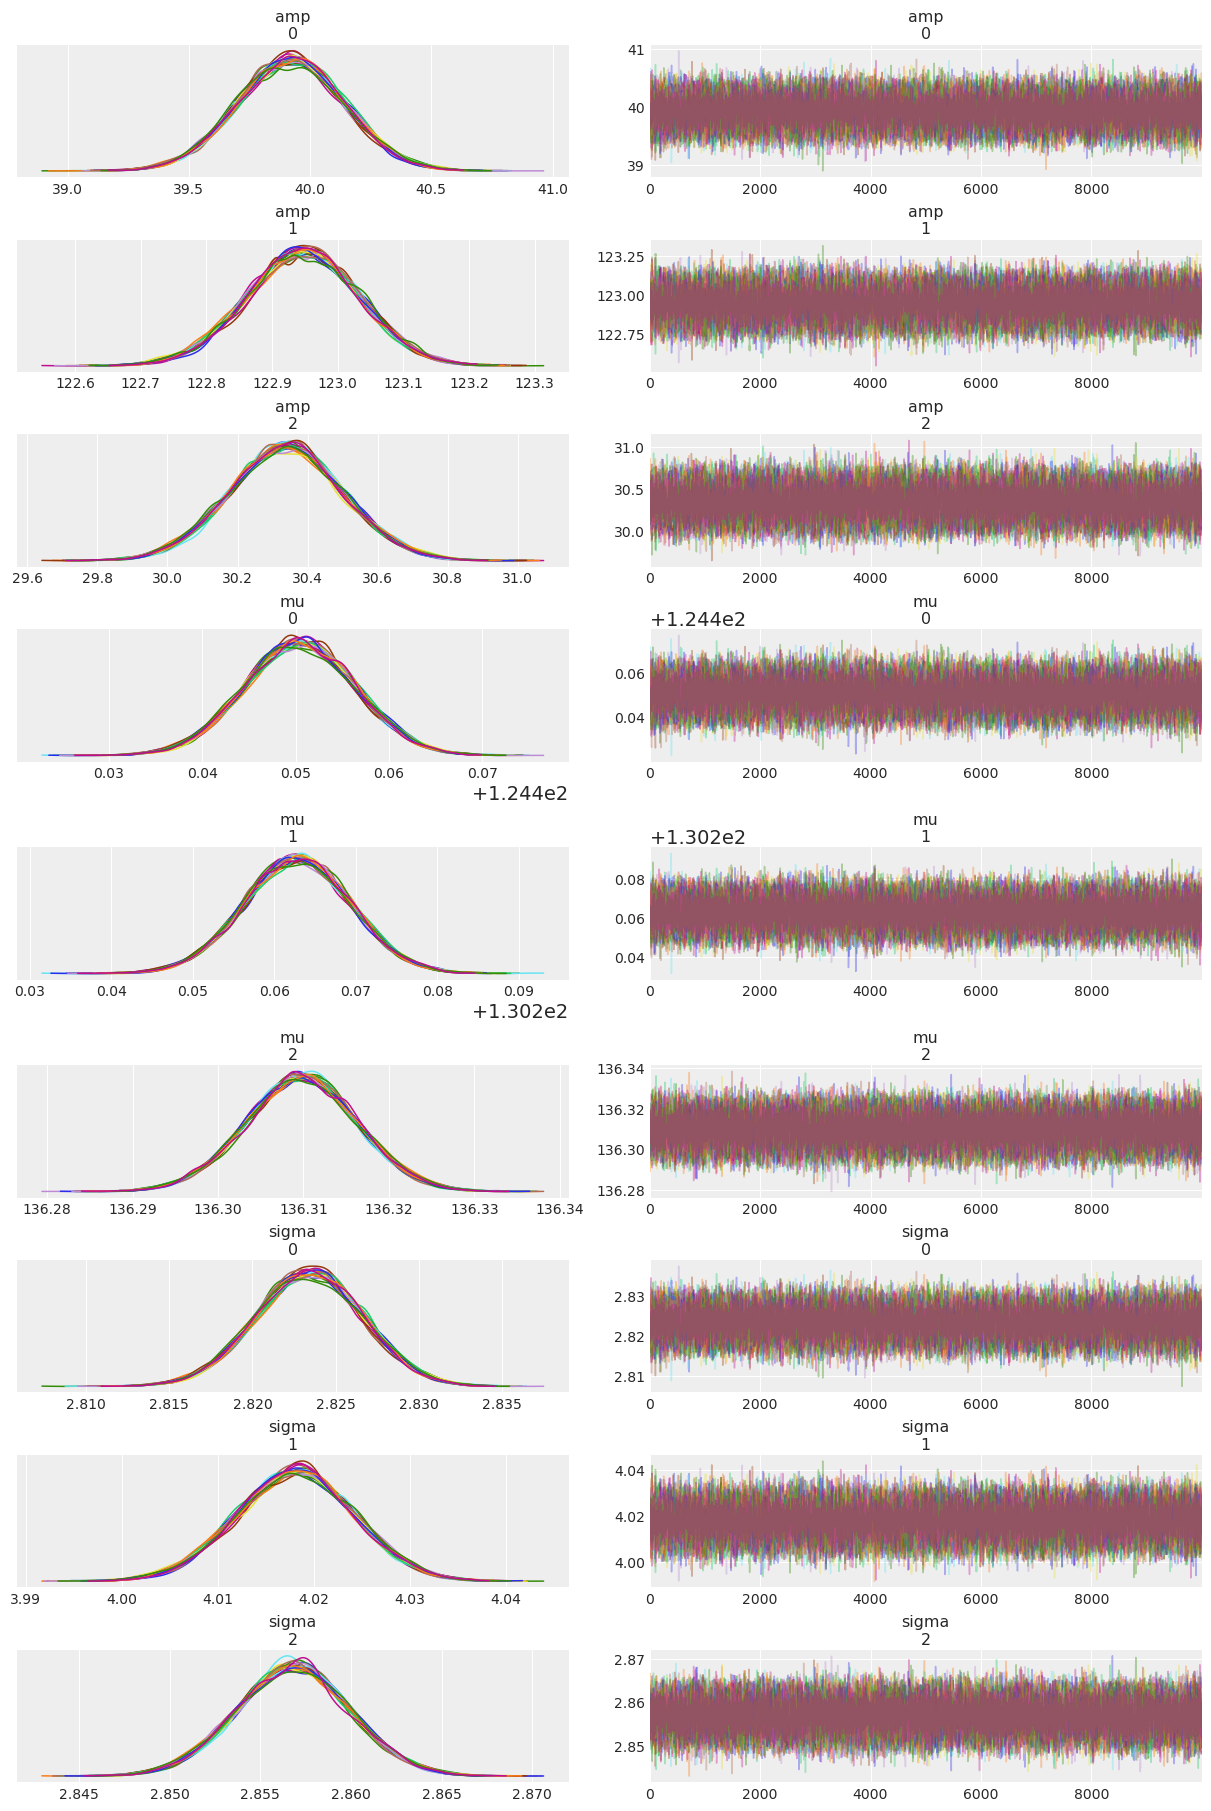

In [39]:
axes = az.plot_trace(trace, compact=False);

corner.corner(trace, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt = '.4e');

post = trace.posterior
mean = post.mean(dim=["chain", "draw"])
amp = mean.amp.values
mu = mean.mu.values
sig = mean.sigma.values
model = np.zeros(len(spec))
x = np.arange(len(spec))
for i in range(num):
    model += amp[i] * np.exp(-((x - mu[i]) ** 2) / (2 * sig[i] ** 2))

fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
axs[0].set(title=name + " Stokes I Fit", ylabel = "Flux Density (Jy)")
axs[0].plot(x_axis, spec, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0].plot(x_axis, model, label = 'Fit', color = 'c')
axs[0].plot(x_axis, spec - model, 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0].errorbar(x_axis, spec - model, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(num):
    axs[0].plot(x_axis, amp[i] * np.exp(-((x - mu[i]) ** 2) / (2 * sig[i] ** 2)), label = f'Gauss{i}', alpha = 0.5)
    print('Amp:' , f"{amp[i]:.2f}", 'Center:', f"{mu[i]:.2f}", 'Width:', f"{sig[i]:.2f}", sep='\t') # Print to file

axs[0].legend()
axs[1].plot(x_axis, (spec - model), label = 'Residuals')
axs[1].set(xlabel = "Frequency (GHz)")
axs[1].legend()
print('Chi2:', np.sum((spec - model)**2))
plt.show()
I_fit = model

In [40]:
# Comparing Different Fitting Methods

ref_g = (models.Gaussian1D(amplitude=103.73, mean=-2.218, stddev=0.263 / 2.355) + 
         models.Gaussian1D(amplitude=73.26, mean=-2.052, stddev=0.223 / 2.355))

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey='row')
axs[0][0].set(title=name + " Least Squared Stokes I Fit", ylabel = "Flux Density (Jy)")
axs[0][0].plot(spec, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0][0].plot(np.flip(ref_g(vel_axis)), label = 'Fit', color = 'c')
axs[0][0].plot(spec - np.flip(ref_g(vel_axis)), 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0][0].errorbar(np.arange(len(spec)), spec, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(2):
    axs[0][0].plot(np.flip(ref_g[i](vel_axis)), label = f'Gauss{i}', alpha = 0.5)
#     print('Amp:' , f"{amp[i]:.2f}", 'Center:', f"{mu[i]:.2f}", 'Width:', f"{sig[i]:.2f}", sep='\t') # Print to file

axs[0][0].legend()
axs[1][0].plot((spec - np.flip(ref_g(vel_axis))), label = 'Residuals')
axs[1][0].set(xlabel = "Channels (Frequency)")
axs[1][0].legend(title=f'$\chi^2$ = {np.sum((spec - np.flip(ref_g(vel_axis)))**2):.2f}')
print('Chi2:', np.sum((spec - np.flip(ref_g(vel_axis)))**2))


post = trace.posterior
mean = post.mean(dim=["chain", "draw"])
amp = mean.amp.values
mu = mean.mu.values
sig = mean.sigma.values
model = np.zeros(len(spec))
x = np.arange(len(spec))
for i in range(num):
    model += amp[i] * np.exp(-((x - mu[i]) ** 2) / (2 * sig[i] ** 2))
axs[0][1].set(title=name + " MCMC Stokes I Fit")
axs[0][1].plot(spec, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0][1].plot(model, label = 'Fit', color = 'c')
axs[0][1].plot(spec - model, 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0][1].errorbar(np.arange(len(spec)), spec, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(num):
    axs[0][1].plot(amp[i] * np.exp(-((x - mu[i]) ** 2) / (2 * sig[i] ** 2)), label = f'Gauss{i}', alpha = 0.5)
#     print('Amp:' , f"{amp[i]:.2f}", 'Center:', f"{mu[i]:.2f}", 'Width:', f"{sig[i]:.2f}", sep='\t') # Print to file

axs[0][1].legend()
axs[1][1].plot((spec - model), label = 'Residuals')
axs[1][1].set(xlabel = "Channels (Frequency)")
axs[1][1].legend(title=f'$\chi^2$ = {np.sum((spec - model)**2):.2f}')
print('Chi2:', np.sum((spec - model)**2))

plt.show()
I_fit = model

Chi2: 50.505944529819644
Chi2: 4.500610604109031


In [95]:
stokesVmodel = pm.Model()
compoments = np.array([amp[i] * np.exp(-0.5 * ((xs - mu[i]) / sig[i]) ** 2) for i in range(num)])

with stokesVmodel as model:
    I = pm.Data("I", I_fit)
    d_I = pm.Data("d_I", np.gradient(compoments, d_nu, axis = 1))
    alpha = pm.Flat("alpha", shape = 1)
    beta = pm.Flat("beta", shape = num)
    V_fit = alpha * I + pm.math.sum([beta[i] * d_I[i] for i in range(num)], axis=0)
    V_likelihood = pm.Normal("V", mu=V_fit, observed=V, sigma=0.01)
    
    V_trace = pm.sample(draws=10_000, tune=5_000, cores = 24, chains = 24, discard_tuned_samples=False, step = pm.NUTS())

/users/rhsu/micromamba/envs/pymc_env/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Multiprocess sampling (24 chains in 24 jobs)
NUTS: [alpha, beta]


Sampling 24 chains for 5_000 tune and 10_000 draw iterations (120_000 + 240_000 draws total) took 43 seconds.


/users/rhsu/micromamba/envs/pymc_env/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


Chi2: 0.04757677203734581


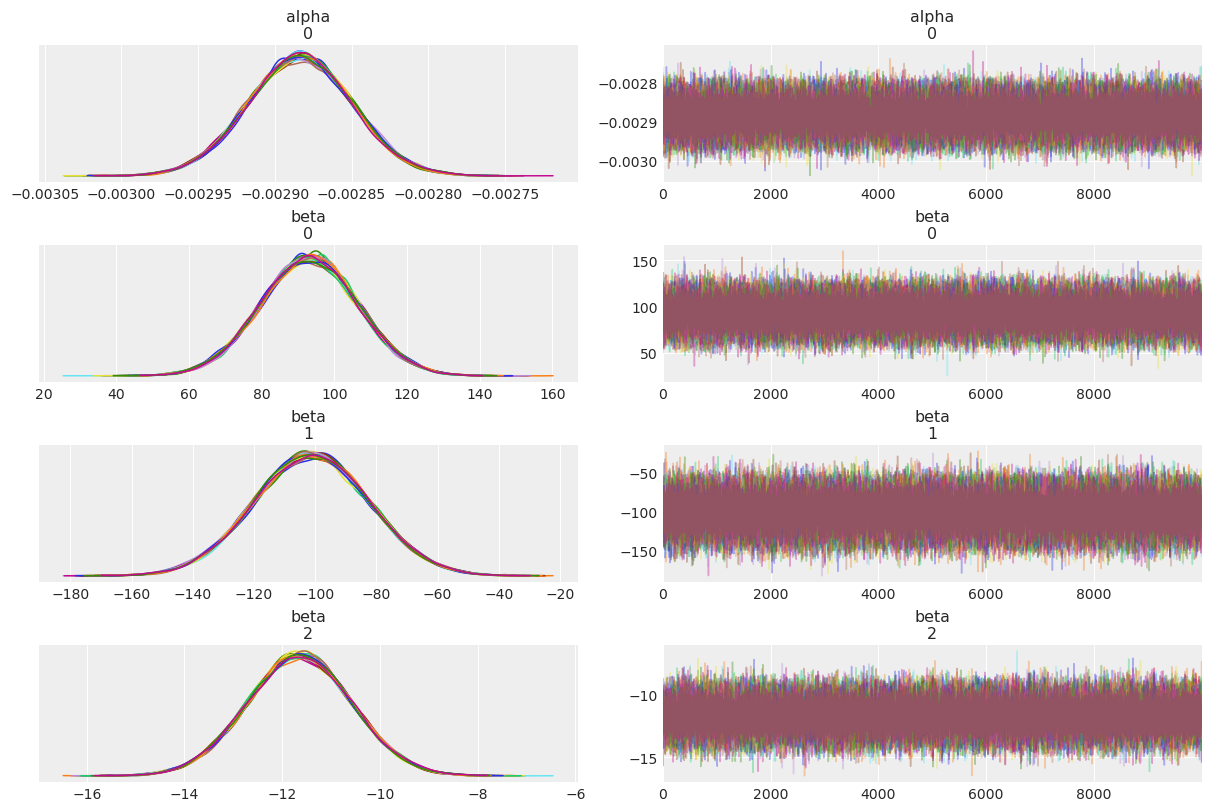

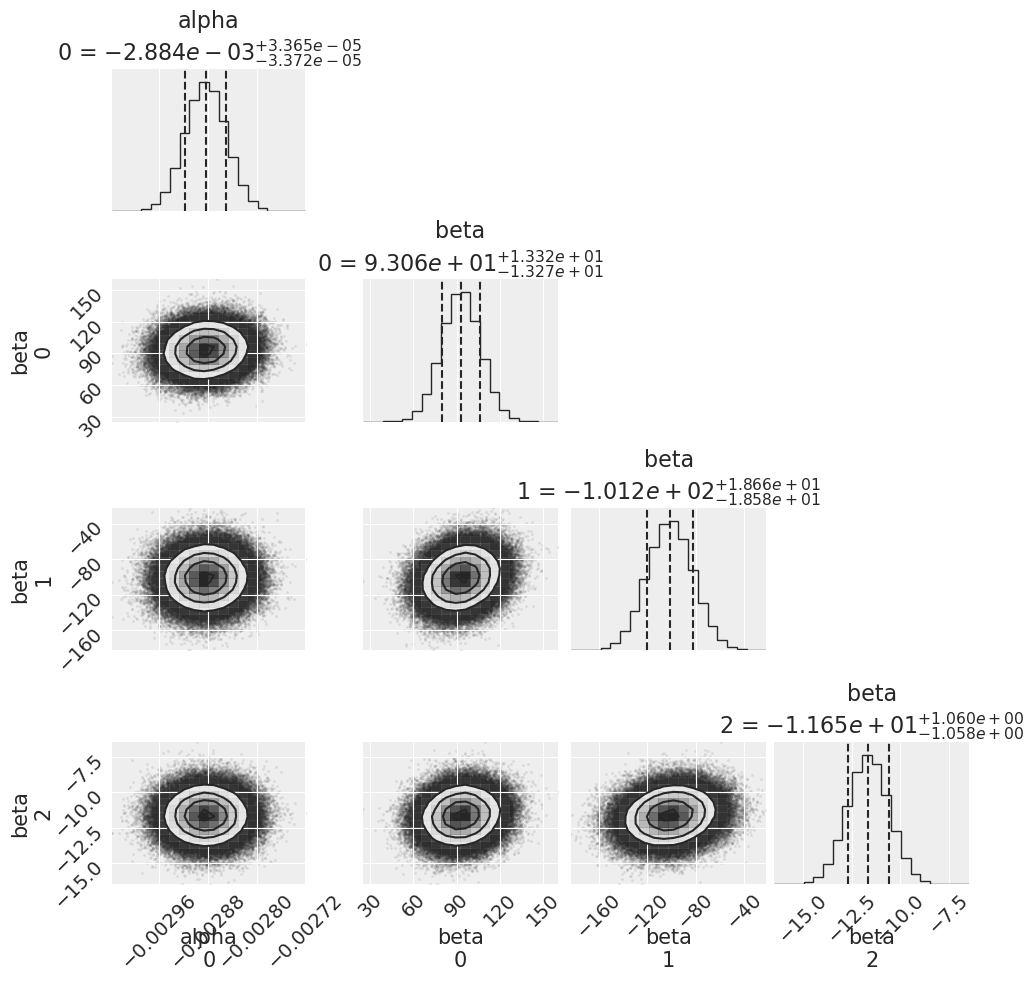

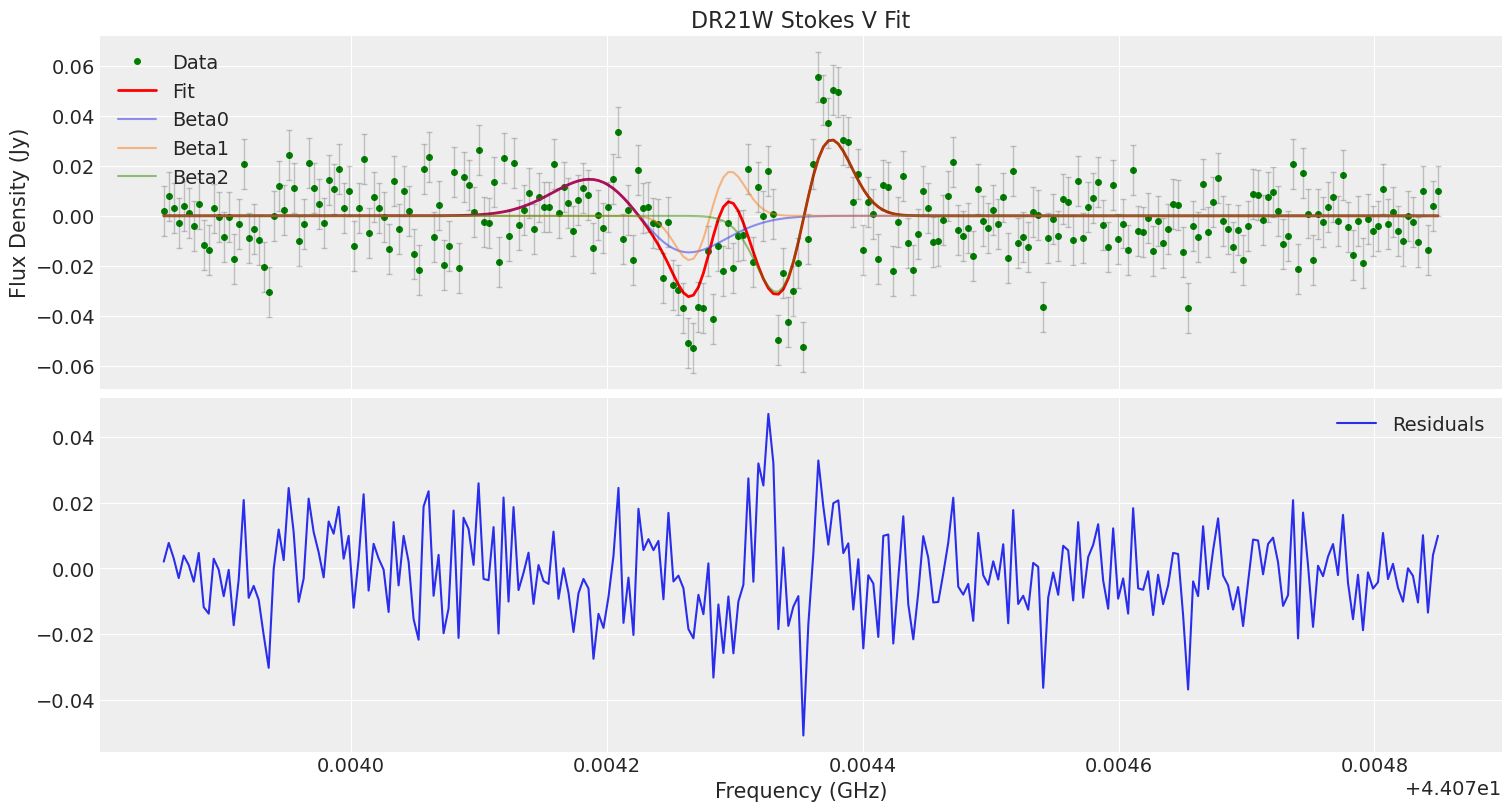

In [104]:
axes = az.plot_trace(V_trace, compact=False);

corner.corner(V_trace, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt = '.3e');

post = V_trace.posterior
mean = post.mean(dim=["chain", "draw"])
alpha = mean.alpha.values
beta = mean.beta.values
V_model = alpha * I_fit + np.sum([beta[i] * np.gradient(compoments, d_nu, axis = 1)[i] for i in range(num)], axis=0)

fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
axs[0].set(title=name + " Stokes V Fit", ylabel = "Flux Density (Jy)")
axs[0].plot(x_axis, V - alpha * I_fit, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0].plot(x_axis, V_model - alpha * I_fit, label = 'Fit', color = 'r', linewidth = 2)
# axs[0].plot(x_axis, V - V_model, 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0].errorbar(x_axis, V - alpha * I_fit, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(num):
    axs[0].plot(x_axis, beta[i] * np.gradient(compoments[i], d_nu), label = f'Beta{i}', alpha = 0.5)
    # print('Amp:' , f"{amp[i]:.2f}", 'Center:', f"{mu[i]:.2f}", 'Width:', f"{sig[i]:.2f}", sep='\t') # Print to file

axs[0].legend()
axs[1].plot(x_axis, (V - V_model), label='Residuals')
axs[1].set(xlabel = "Frequency (GHz)")
axs[1].legend()
print('Chi2:', np.sum((V - V_model)**2))
plt.show()

Chi2: 177.63463617007895
Chi2: 0.04757677203734581


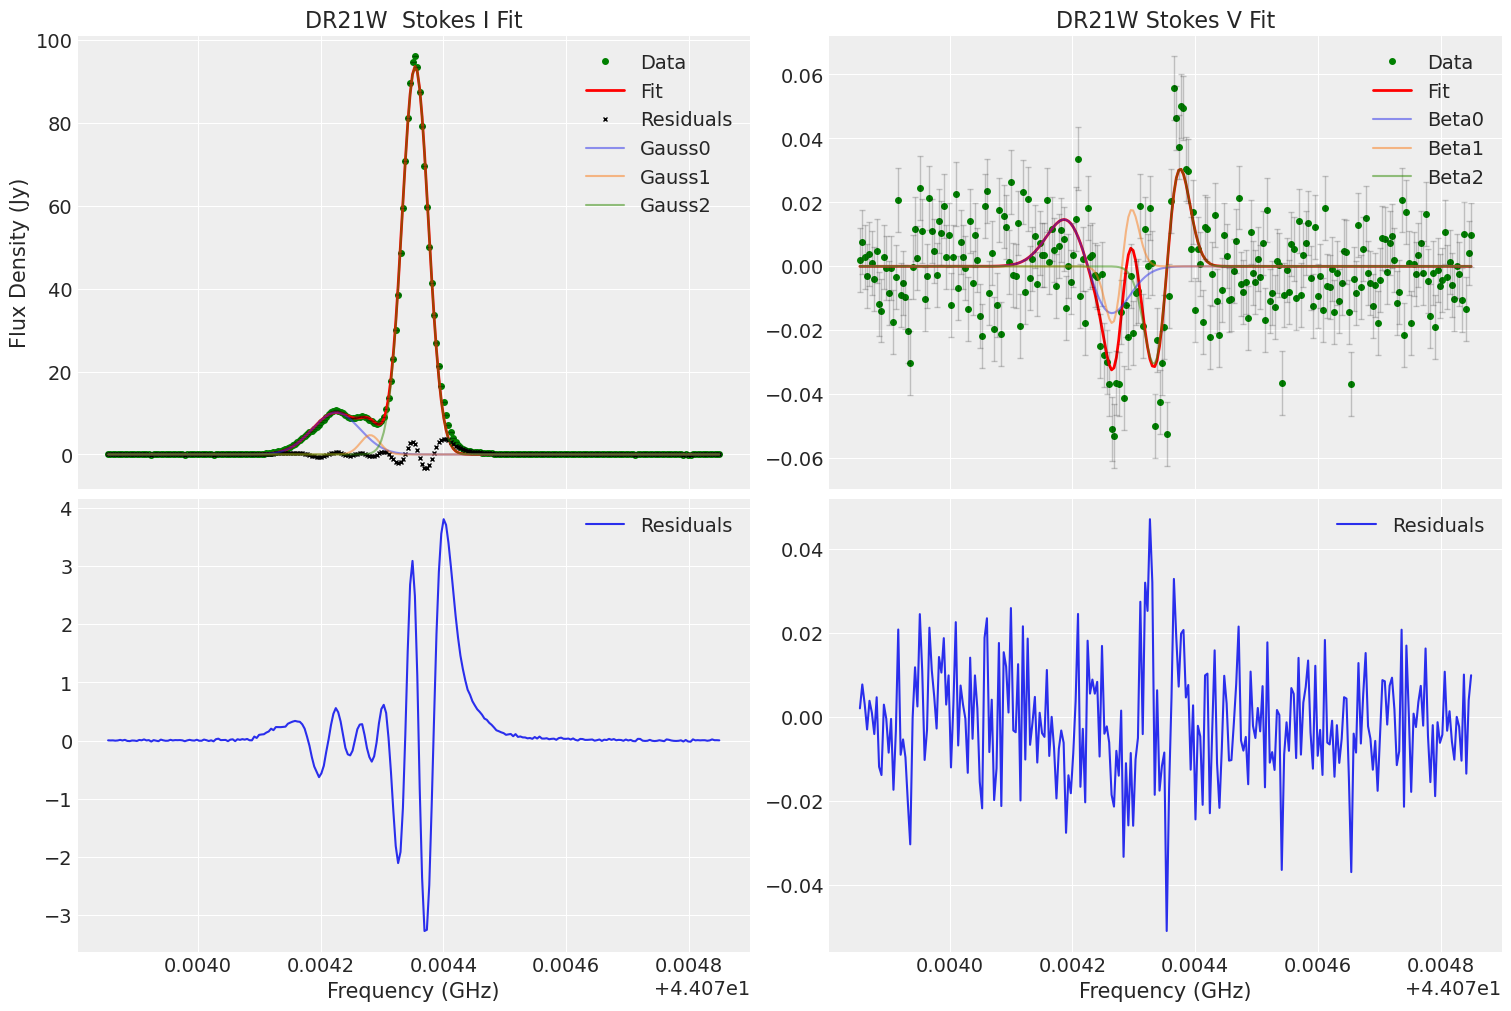

In [103]:
x = np.arange(len(spec))
model = np.zeros(len(spec))
for i in range(num):
    model += amp[i] * np.exp(-((x - mu[i]) ** 2) / (2 * sig[i] ** 2))

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=False)
axs[0][0].set(title=name + "  Stokes I Fit", ylabel = "Flux Density (Jy)")
axs[0][0].plot(x_axis, spec, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0][0].plot(x_axis, model, label = 'Fit', color = 'r', linewidth = 2)
axs[0][0].plot(x_axis, spec - model, 'x', markersize = 3, color = 'black', label = 'Residuals')
axs[0][0].errorbar(x_axis, spec, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(3):
    axs[0][0].plot(x_axis, amp[i] * np.exp(-((x - mu[i]) ** 2) / (2 * sig[i] ** 2)), label = f'Gauss{i}', alpha = 0.5)
#     print('Amp:' , f"{amp[i]:.2f}", 'Center:', f"{mu[i]:.2f}", 'Width:', f"{sig[i]:.2f}", sep='\t') # Print to file

axs[0][0].legend()
axs[1][0].plot(x_axis, (spec - model), label = 'Residuals')
axs[1][0].set(xlabel = "Frequency (GHz)")
axs[1][0].legend()
print('Chi2:', np.sum((spec - model)**2))

I_fit = model

axs[0][1].set(title=name + " Stokes V Fit")
axs[0][1].plot(x_axis, V - alpha * I_fit, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0][1].plot(x_axis, V_model - alpha * I_fit, label = 'Fit', color = 'r', linewidth = 2)
# axs[0][1].plot(x_axis, V - V_model, 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0][1].errorbar(x_axis, V - alpha * I_fit, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(num):
    axs[0][1].plot(x_axis, beta[i] * np.gradient(compoments[i], d_nu), label = f'Beta{i}', alpha = 0.5)

axs[0][1].legend()
axs[1][1].plot(x_axis, (V - V_model), label = 'Residuals')
axs[1][1].set(xlabel = "Frequency (GHz)")
axs[1][1].legend()
print('Chi2:', np.sum((V - V_model)**2))

plt.show()

In [101]:
from astropy.modeling.fitting import LevMarLSQFitter
guess = guess_gen(spec, 2)
g = models.Gaussian1D(amplitude=guess[0], mean=guess[1], stddev=guess[2],
                    bounds={'amplitude': (0, np.max(spec)), 
                            'mean': (guess[1] - 3*guess[2], guess[-2] + 3*guess[-1]), 
                            'stddev': (0, len(spec))})

for i in range(3, len(guess), 3):
    g += models.Gaussian1D(amplitude=guess[i], mean=guess[i+1], stddev=guess[i+2],
                    bounds={'amplitude': (0, np.max(spec)), 
                            'mean': (guess[1] - 3*guess[2], guess[-2] + 3*guess[-1]), 
                            'stddev': (0, len(spec))})

@custom_model
def StokesValpha(I, alpha=1):
    return alpha * I
@custom_model
def StokesVbeta(I, beta=1):
    return beta * np.gradient(I, d_nu)

fitter = LevMarLSQFitter()
g_fit = fitter(g, xs, spec, maxiter=10000)
g_copy = g_fit.copy()
g_copy.parameters.fixed = True
stokesV = g_fit | StokesValpha()
for i in range(2): stokesV += (g_fit[i] | StokesVbeta())


stokesv_fit = fitter(stokesV, xs, V, maxiter=10000)

AttributeError: 'numpy.ndarray' object has no attribute 'fixed'

Chi2: 36920.18966489192
Chi2: 0.031041305193408187


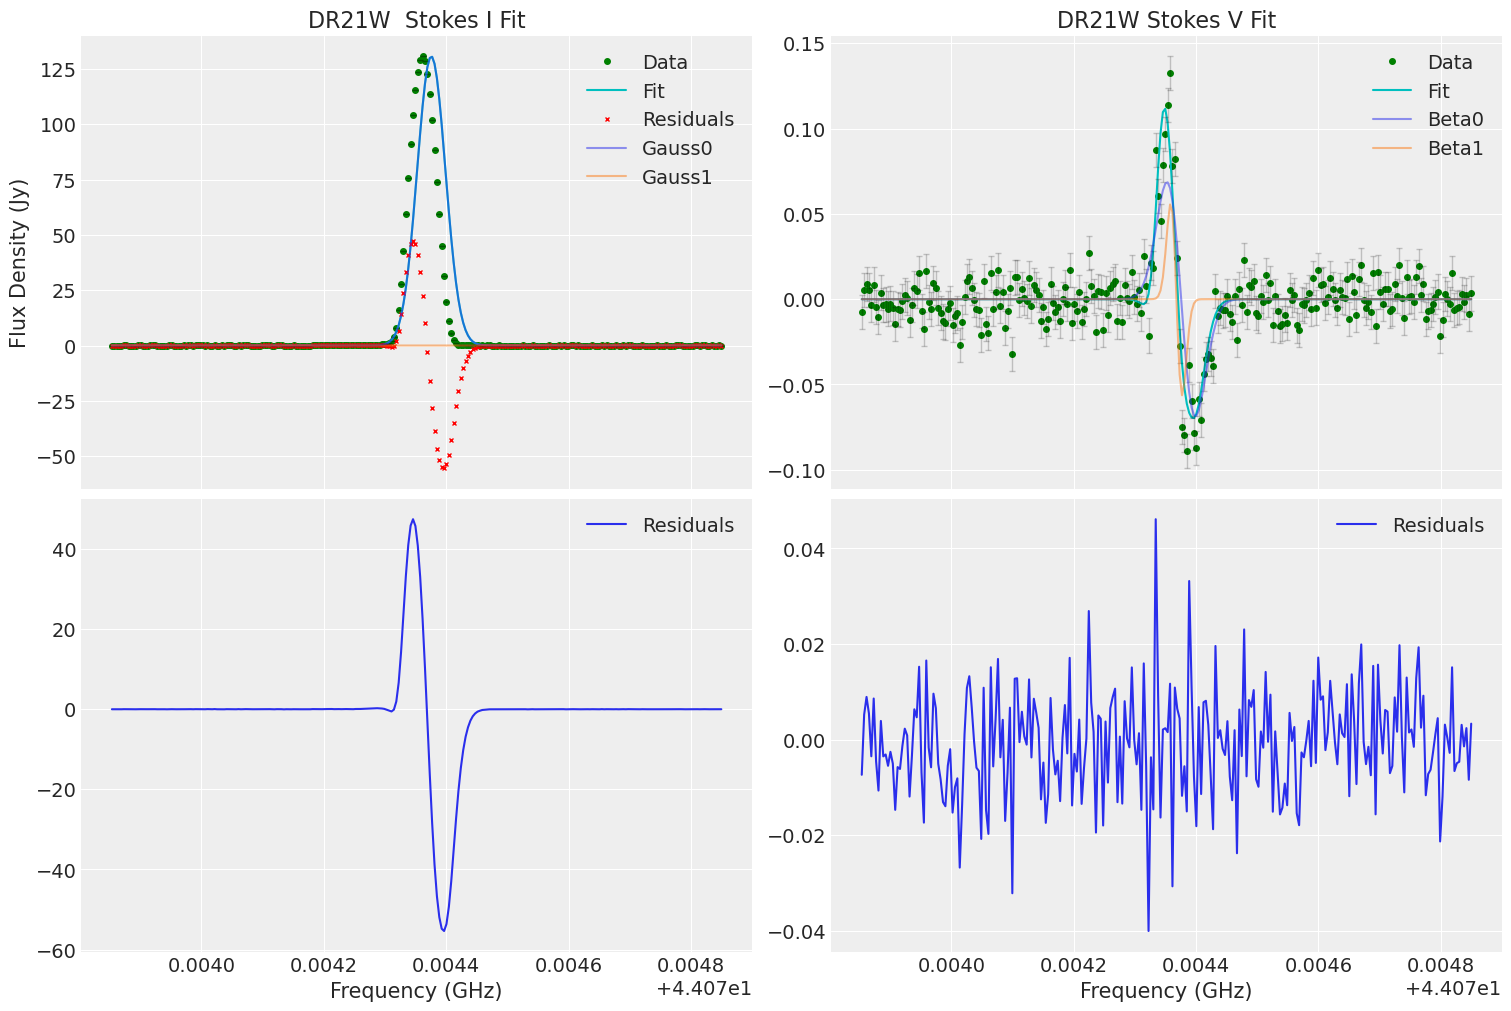

In [100]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=False)
axs[0][0].set(title=name + "  Stokes I Fit", ylabel = "Flux Density (Jy)")
axs[0][0].plot(x_axis, spec, 'o', color = 'green', label = 'Data', markersize = 4)
axs[0][0].plot(x_axis, stokesv_fit[:2](xs), label = 'Fit', color = 'c')
axs[0][0].plot(x_axis, spec - stokesv_fit[:2](xs), 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0][0].errorbar(x_axis, spec, yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(2):
    axs[0][0].plot(x_axis, stokesv_fit[i](xs), label = f'Gauss{i}', alpha = 0.5)
#     print('Amp:' , f"{amp[i]:.2f}", 'Center:', f"{mu[i]:.2f}", 'Width:', f"{sig[i]:.2f}", sep='\t') # Print to file

axs[0][0].legend()
axs[1][0].plot(x_axis, (spec - stokesv_fit[:2](xs)), label = 'Residuals')
axs[1][0].set(xlabel = "Frequency (GHz)")
axs[1][0].legend()
print('Chi2:', np.sum((spec - stokesv_fit[:2](xs))**2))

I_fit = model

axs[0][1].set(title=name + " Stokes V Fit")
axs[0][1].plot(x_axis, V - stokesv_fit[:3](xs), 'o', color = 'green', label = 'Data', markersize = 4)
axs[0][1].plot(x_axis, V_model - stokesv_fit[:3](xs), label = 'Fit', color = 'c')
# axs[0][1].plot(x_axis, V - V_model, 'x', markersize = 3, color = 'red', label = 'Residuals')
axs[0][1].errorbar(x_axis, V - stokesv_fit[:3](xs), yerr = 0.01, fmt = 'none', ecolor = 'k', elinewidth = 1, capsize = 2, alpha = 0.2)

for i in range(2):
    axs[0][1].plot(x_axis, stokesv_fit[3+i*2:3+i*2+2](xs), label = f'Beta{i}', alpha = 0.5)

axs[0][1].legend()
axs[1][1].plot(x_axis, (V - stokesv_fit(xs)), label = 'Residuals')
axs[1][1].set(xlabel = "Frequency (GHz)")
axs[1][1].legend()
print('Chi2:', np.sum((V - stokesv_fit(xs))**2))

plt.show()